## Лабораторная работа №1

Выполнила: Кудаева Вика М8О-310Б-23

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectPercentile, f_regression
import warnings
import inspect

warnings.filterwarnings('ignore')

#### Анализ исходного датасета

ОСНОВНАЯ ИНФОРМАЦИЯ О ДАННЫХ
Размер обучающей выборки: (11017, 35)
Размер тестовой выборки: (5000, 35)

Первые 5 строк обучающей выборки:
  ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   
4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0   

  MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0      Divorced                 1.0                Rent               1095.0   
1       Widowed                 1.0            Mortgage                211.0   
2       Married                 0.0            Mortgage                546.0   
3       Married                 0.0               Other      

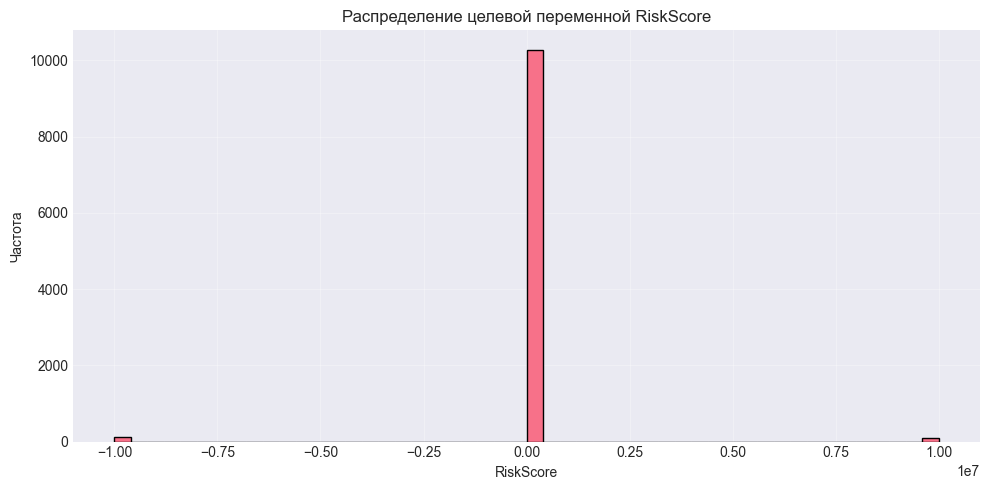


Статистика RiskScore:
Среднее: -25698.78
Медиана: 44.12
Стандартное отклонение: 1431674.59
Мин: -9999999.00, Макс: 10000000.00

ГРАФИКИ ЗАВИСИМОСТИ ПРИЗНАКОВ ДРУГ ОТ ДРУГА


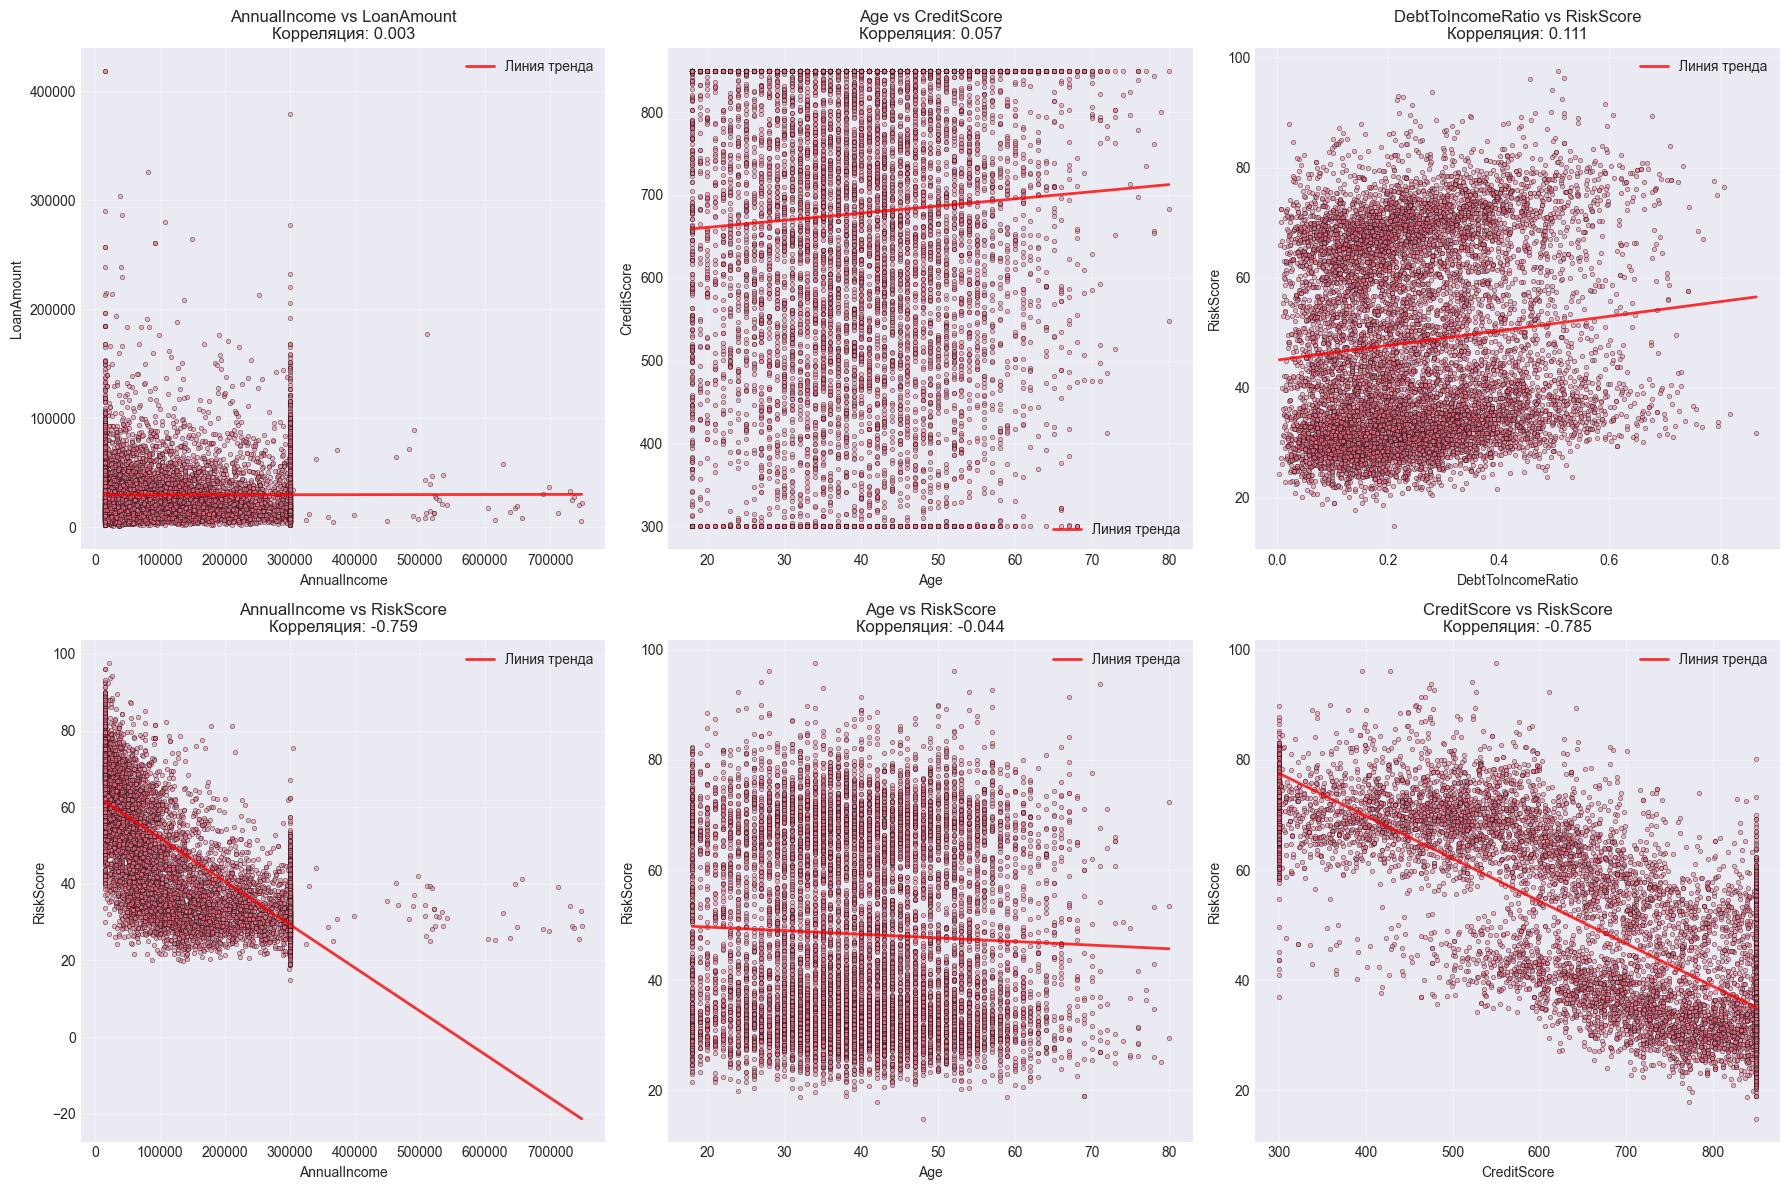

МАТРИЦА КОРРЕЛЯЦИЙ


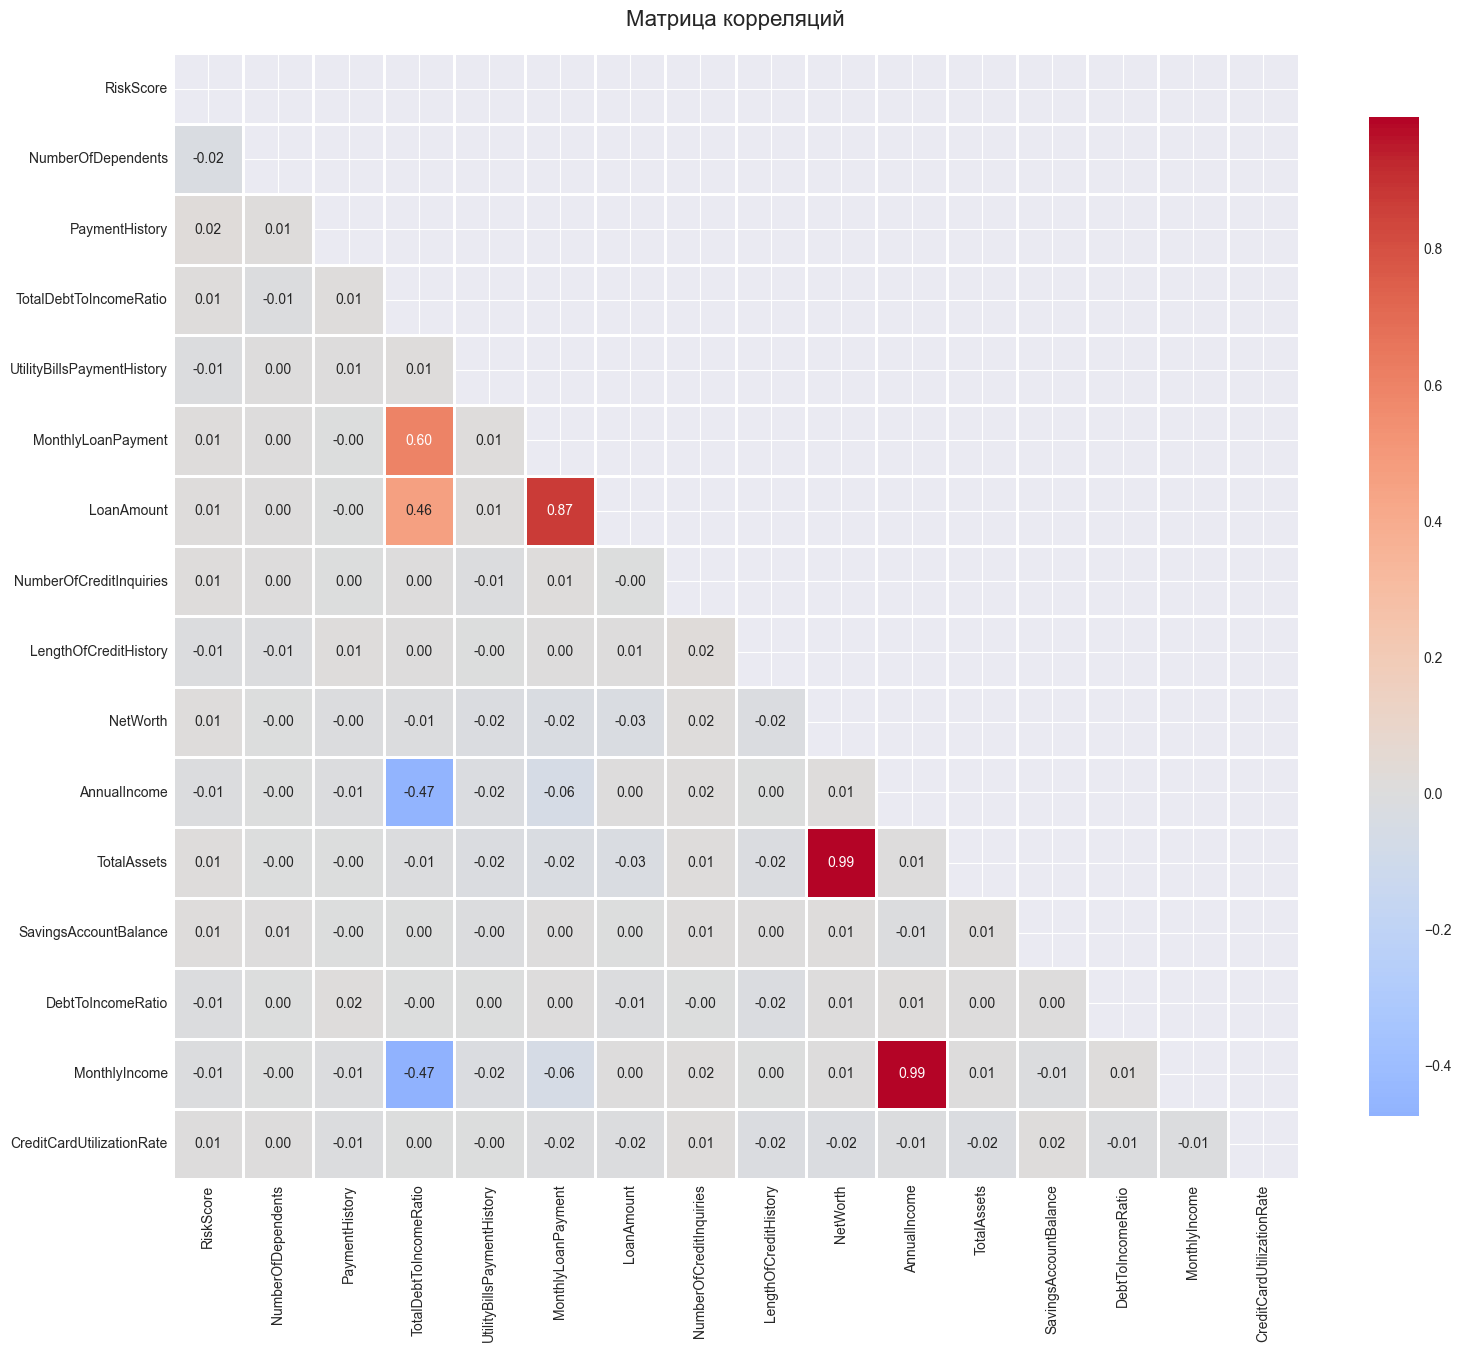

In [20]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("=" * 60)
print("ОСНОВНАЯ ИНФОРМАЦИЯ О ДАННЫХ")
print("=" * 60)

print(f"Размер обучающей выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")
print()

print("Первые 5 строк обучающей выборки:")
print(train_df.head())
print()

print("=" * 60)
print("АНАЛИЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ")
print("=" * 60)

missing_values = train_df.isnull().sum()
missing_percent = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Количество пропусков': missing_values,
    'Процент пропусков': missing_percent
})
print(missing_df[missing_df['Количество пропусков'] > 0])
print()

print("=" * 60)
print("СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ ЧИСЛОВЫХ ПРИЗНАКОВ")
print("=" * 60)

numeric_cols = train_df.select_dtypes(include=[np.number]).columns
print(train_df[numeric_cols].describe().T.round(2))
print()

print("=" * 60)
print("РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (RiskScore)")
print("=" * 60)

plt.figure(figsize=(10, 5))
plt.hist(train_df['RiskScore'], bins=50, edgecolor='black')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.title('Распределение целевой переменной RiskScore')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nСтатистика RiskScore:")
print(f"Среднее: {train_df['RiskScore'].mean():.2f}")
print(f"Медиана: {train_df['RiskScore'].median():.2f}")
print(f"Стандартное отклонение: {train_df['RiskScore'].std():.2f}")
print(f"Мин: {train_df['RiskScore'].min():.2f}, Макс: {train_df['RiskScore'].max():.2f}")
print()

print("=" * 60)
print("ГРАФИКИ ЗАВИСИМОСТИ ПРИЗНАКОВ ДРУГ ОТ ДРУГА")
print("=" * 60)

train_df_limited = train_df[train_df['RiskScore'].between(-1000, 1000)].copy()

key_features = ['AnnualIncome', 'Age', 'CreditScore', 'LoanAmount', 'DebtToIncomeRatio', 'RiskScore']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

pairs = [
    ('AnnualIncome', 'LoanAmount'),
    ('Age', 'CreditScore'),
    ('DebtToIncomeRatio', 'RiskScore'),
    ('AnnualIncome', 'RiskScore'),
    ('Age', 'RiskScore'),
    ('CreditScore', 'RiskScore')
]

for i, (x_feature, y_feature) in enumerate(pairs):
    if x_feature in train_df_limited.columns and y_feature in train_df_limited.columns:

        valid_data = train_df_limited[[x_feature, y_feature]].dropna()
        if len(valid_data) > 10: 
            axes[i].scatter(valid_data[x_feature], valid_data[y_feature], 
                           alpha=0.5, s=10, edgecolor='k', linewidth=0.5)
            axes[i].set_xlabel(x_feature)
            axes[i].set_ylabel(y_feature)
            correlation = valid_data[x_feature].corr(valid_data[y_feature])
            axes[i].set_title(f'{x_feature} vs {y_feature}\nКорреляция: {correlation:.3f}')
            try:
                z = np.polyfit(valid_data[x_feature], valid_data[y_feature], 1)
                p = np.poly1d(z)
                x_sorted = np.sort(valid_data[x_feature])
                axes[i].plot(x_sorted, p(x_sorted), "r-", linewidth=2, alpha=0.8, label='Линия тренда')
                axes[i].legend()
            except:
                pass
            
            axes[i].grid(True, alpha=0.3)
        else:
            axes[i].text(0.5, 0.5, f'Недостаточно данных\nдля {x_feature} и {y_feature}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{x_feature} vs {y_feature}')
            axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, f'Признак отсутствует\n{x_feature} или {y_feature}', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{x_feature} vs {y_feature}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

print("=" * 60)
print("МАТРИЦА КОРРЕЛЯЦИЙ")
print("=" * 60)

correlation_with_target = train_df[numeric_cols].corr()['RiskScore'].abs().sort_values(ascending=False)
top_features = correlation_with_target.index[:16] 
plt.figure(figsize=(16, 14))
corr_matrix = train_df[top_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

**Вывод:** анализ качества данных показывает, что набор содержит значительное количество пропущенных значений (от 4.8% до 9.4% по разным признакам) и экстремальные выбросы, особенно в целевой переменной RiskScore (максимальное значение 10,000,000 против нормального диапазона до 100), что требует обязательной предварительной очистки данных и корректной обработки пропусков перед построением линейной регрессии для достижения целевой метрики MSE < 25.

#### Класс для нормализации данных

In [12]:
class CustomScaler:

    def __init__(self, method='zscore'):
        self.method = method
        self.mean_ = None
        self.std_ = None
        self.min_ = None
        self.max_ = None

    def fit(self, X):
        if self.method == 'zscore':
            self.mean_ = np.mean(X, axis=0)
            self.std_ = np.std(X, axis=0)
            self.std_[self.std_ == 0] = 1
        elif self.method == 'minmax':
            self.min_ = np.min(X, axis=0)
            self.max_ = np.max(X, axis=0)
        else:
            raise ValueError(f"Неизвестный метод: {self.method}")
        return self

    def transform(self, X):
        if self.method == 'zscore':
            return (X - self.mean_) / self.std_
        elif self.method == 'minmax':
            range_vals = self.max_ - self.min_
            range_vals[range_vals == 0] = 1
            return (X - self.min_) / range_vals

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X):
        if self.method == 'zscore':
            return X * self.std_ + self.mean_
        elif self.method == 'minmax':
            range_vals = self.max_ - self.min_
            range_vals[range_vals == 0] = 1
            return X * range_vals + self.min_

#### Класс линейной регрессии

In [13]:
class LinearRegressionCustom:
    def __init__(self, method='analytical', learning_rate=0.01, n_iterations=1000,
                 batch_size=32, regularization=None, lambda_reg=0.01, p_value=1.5,
                 random_state=42, verbose=False):
        self.method = method
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.regularization = regularization
        self.lambda_reg = lambda_reg
        self.p_value = p_value
        self.random_state = random_state
        self.verbose = verbose

        self.weights = None
        self.bias = None
        self.loss_history = []
        np.random.seed(random_state)

    def _add_bias(self, X):
        return np.c_[np.ones((X.shape[0], 1)), X]

    def _regularization_term(self, weights):
        if self.regularization == 'l1':
            return self.lambda_reg * np.sum(np.abs(weights))
        elif self.regularization == 'l2':
            return self.lambda_reg * np.sum(weights ** 2)
        elif self.regularization == 'elasticnet':
            l1_term = 0.5 * self.lambda_reg * np.sum(np.abs(weights))
            l2_term = 0.5 * self.lambda_reg * np.sum(weights ** 2)
            return l1_term + l2_term
        elif self.regularization == 'lp':
            return self.lambda_reg * np.sum(np.abs(weights) ** self.p_value)
        else:
            return 0

    def _regularization_gradient(self, weights):
        if self.regularization == 'l1':
            return self.lambda_reg * np.sign(weights)
        elif self.regularization == 'l2':
            return 2 * self.lambda_reg * weights
        elif self.regularization == 'elasticnet':
            return self.lambda_reg * (np.sign(weights) + weights)
        elif self.regularization == 'lp':
            return self.lambda_reg * self.p_value * np.sign(weights) * (np.abs(weights) ** (self.p_value - 1))
        else:
            return 0

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).flatten()
        X = np.nan_to_num(X, nan=0.0)
        y = np.nan_to_num(y, nan=0.0)

        if self.method == 'analytical':
            self._fit_analytical(X, y)
        elif self.method == 'sgd':
            self._fit_sgd(X, y)
        else:
            raise ValueError(f"Неизвестный метод: {self.method}")
        return self

    def _fit_analytical(self, X, y):
        X_b = self._add_bias(X)

        if self.regularization == 'l2':
            I = np.eye(X_b.shape[1])
            I[0, 0] = 0
            theta = np.linalg.pinv(X_b.T @ X_b + self.lambda_reg * I) @ X_b.T @ y
        elif self.regularization == 'l1' or self.regularization == 'lp':
            self._fit_sgd(X, y)
            return
        else:
            theta = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y

        self.bias = theta[0]
        self.weights = theta[1:]

        if self.verbose:
            print(f"  Аналитический метод завершен")

    def _fit_sgd(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for epoch in range(self.n_iterations):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]

                y_pred = X_batch @ self.weights + self.bias
                error = y_pred - y_batch

                dw = (1 / len(X_batch)) * (X_batch.T @ error) + self._regularization_gradient(self.weights)
                db = (1 / len(X_batch)) * np.sum(error)

                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

            # Сохраняем loss для истории
            if self.verbose and epoch % 100 == 0:
                y_pred_full = X @ self.weights + self.bias
                loss = np.mean((y_pred_full - y) ** 2) + self._regularization_term(self.weights)
                self.loss_history.append(loss)

        if self.verbose:
            print(f"  SGD завершен: {self.n_iterations} эпох, batch_size={self.batch_size}")

    def predict(self, X):
        X = np.array(X)
        X = np.nan_to_num(X, nan=0.0)
        return X @ self.weights + self.bias

### Класс для кросс-валидации данных

In [14]:
class CustomCrossValidator:
    def __init__(self, cv_type='kfold', n_splits=5, shuffle=True, random_state=42):
        self.cv_type = cv_type
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X, y=None):
        n = len(X)
        indices = np.arange(n)

        if self.shuffle:
            rng = np.random.RandomState(self.random_state)
            rng.shuffle(indices)

        if self.cv_type == 'kfold':
            fold_sizes = np.full(self.n_splits, n // self.n_splits, dtype=int)
            fold_sizes[:n % self.n_splits] += 1
            current = 0

            for fold_size in fold_sizes:
                start, stop = current, current + fold_size
                test_idx = indices[start:stop]
                train_idx = np.concatenate((indices[:start], indices[stop:]))
                yield train_idx, test_idx
                current = stop

        elif self.cv_type == 'loo':
            for i in range(n):
                test_idx = [indices[i]]
                train_idx = np.delete(indices, i)
                yield train_idx, test_idx

#### Метрики

In [15]:
def custom_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)


def custom_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def custom_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / (ss_tot + EPS))


def custom_mape(y_true, y_pred):
    mask = y_true != 0
    if np.sum(mask) == 0:
        return 0
    return 100 * np.mean(np.abs((y_true[mask] - y_pred[mask]) / (y_true[mask] + EPS)))

In [16]:
class AdvancedPipeline:
    def __init__(self, reg_method='sklearn', lr=0.01, epochs=1000, batch_size=32,
                 verbose=False, scaler_type='zscore', use_poly=True, use_feature_selection=True):
        self.reg_method = reg_method
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.scaler_type = scaler_type
        self.use_poly = use_poly
        self.use_feature_selection = use_feature_selection

        self.num_medians = None
        self.cat_modes = None
        self.num_mean = None
        self.num_std = None
        self.num_min = None
        self.num_max = None
        self.poly = None
        self.poly_mean = None
        self.poly_std = None
        self.ohe = None
        self.selector = None
        self.reg = None
        self.numeric_cols = None
        self.cat_cols = None

    def fit(self, X, y, numeric_cols, cat_cols):
        self.numeric_cols = numeric_cols
        self.cat_cols = cat_cols

        X = X.copy()

        self.num_medians = X[numeric_cols].median()
        X[numeric_cols] = X[numeric_cols].fillna(self.num_medians)

        if cat_cols:
            self.cat_modes = X[cat_cols].mode().iloc[0]
            X[cat_cols] = X[cat_cols].fillna(self.cat_modes)

        self.num_mean = X[numeric_cols].mean()
        self.num_std = X[numeric_cols].std().replace(0, 1)
        X[numeric_cols] = (X[numeric_cols] - self.num_mean) / self.num_std

        if self.use_poly:
            self.poly = PolynomialFeatures(degree=2, include_bias=False)
            self.poly.fit(X[numeric_cols])
            poly_train = self.poly.transform(X[numeric_cols])
            poly_cols = self.poly.get_feature_names_out(numeric_cols)
            poly_df = pd.DataFrame(poly_train, columns=poly_cols, index=X.index)

            self.poly_mean = poly_df.mean()
            self.poly_std = poly_df.std().replace(0, 1)
            poly_df = (poly_df - self.poly_mean) / self.poly_std

        if cat_cols:
            ohe_kwargs = {"handle_unknown": "ignore"}
            if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
                ohe_kwargs["sparse_output"] = False
            else:
                ohe_kwargs["sparse"] = False

            self.ohe = OneHotEncoder(**ohe_kwargs)
            self.ohe.fit(X[cat_cols])
            cat_encoded = self.ohe.transform(X[cat_cols])
            cat_cols_encoded = self.ohe.get_feature_names_out(cat_cols)
            cat_df = pd.DataFrame(cat_encoded, columns=cat_cols_encoded, index=X.index)

        if self.use_poly and cat_cols:
            X_full = pd.concat([poly_df, cat_df], axis=1)
        elif self.use_poly:
            X_full = poly_df
        elif cat_cols:
            X_full = pd.concat([X[numeric_cols], cat_df], axis=1)
        else:
            X_full = X[numeric_cols]

        if self.use_feature_selection:
            self.selector = SelectPercentile(score_func=f_regression, percentile=FEATURE_SELECTION_PERCENTILE)
            self.selector.fit(X_full, y)
            X_sel = self.selector.transform(X_full)
            if self.verbose:
                n_selected = X_sel.shape[1]
                n_total = X_full.shape[1]
        else:
            self.selector = None
            X_sel = X_full

        if self.reg_method == 'sklearn':
            self.reg = LinearRegression()
        elif self.reg_method.startswith('ridge'):
            self.reg = Ridge(alpha=self.lr)
        elif self.reg_method.startswith('lasso'):
            self.reg = Lasso(alpha=self.lr)
        elif self.reg_method.startswith('elastic'):
            self.reg = ElasticNet(alpha=self.lr, l1_ratio=0.5)
        elif self.reg_method == 'sklearn_sgd':

            self.reg = SGDRegressor(
                loss='squared_error',
                penalty='l2',
                alpha=0.0001,
                max_iter=self.epochs,
                learning_rate='constant',
                eta0=self.lr,
                shuffle=True,
                random_state=42,
                verbose=0
            )
        else:

            regularization = None
            if '_l1' in self.reg_method:
                regularization = 'l1'
            elif '_l2' in self.reg_method:
                regularization = 'l2'
            elif '_elastic' in self.reg_method:
                regularization = 'elasticnet'

            self.reg = LinearRegressionCustom(
                method='sgd' if self.reg_method == 'custom_sgd' else 'analytical',
                learning_rate=self.lr,
                n_iterations=self.epochs,
                batch_size=self.batch_size,
                regularization=regularization,
                lambda_reg=self.lr,
                verbose=self.verbose
            )

        self.reg.fit(X_sel, y)

        if self.verbose:
            print(f"Обучение завершено!")

    def transform(self, X):
        X = X.copy()

        X[self.numeric_cols] = X[self.numeric_cols].fillna(self.num_medians)
        if self.cat_cols:
            X[self.cat_cols] = X[self.cat_cols].fillna(self.cat_modes)

        X[self.numeric_cols] = (X[self.numeric_cols] - self.num_mean) / self.num_std

        if self.use_poly:
            poly_test = self.poly.transform(X[self.numeric_cols])
            poly_cols = self.poly.get_feature_names_out(self.numeric_cols)
            poly_df = pd.DataFrame(poly_test, columns=poly_cols, index=X.index)
            poly_df = (poly_df - self.poly_mean) / self.poly_std

        if self.cat_cols:
            cat_encoded = self.ohe.transform(X[self.cat_cols])
            cat_cols_encoded = self.ohe.get_feature_names_out(self.cat_cols)
            cat_df = pd.DataFrame(cat_encoded, columns=cat_cols_encoded, index=X.index)

        if self.use_poly and self.cat_cols:
            X_full = pd.concat([poly_df, cat_df], axis=1)
        elif self.use_poly:
            X_full = poly_df
        elif self.cat_cols:
            X_full = pd.concat([X[self.numeric_cols], cat_df], axis=1)
        else:
            X_full = X[self.numeric_cols]

        if self.use_feature_selection:
            X_sel = self.selector.transform(X_full)
        else:
            X_sel = X_full

        return X_sel

    def predict(self, X):
        X_sel = self.transform(X)
        return self.reg.predict(X_sel)

In [17]:
EPS = 1e-10
FEATURE_SELECTION_PERCENTILE = 30
TARGET_COL = "RiskScore"
ID_COL = "ID"

def signed_log1p(data: np.ndarray) -> np.ndarray:
    return np.sign(data) * np.log1p(np.abs(data))


def extract_date_parts(df: pd.DataFrame, column: str) -> None:
    if column not in df.columns:
        return

    parsed = pd.to_datetime(df[column], errors="coerce")
    df[f"{column}_Year"] = parsed.dt.year
    df[f"{column}_Month"] = parsed.dt.month
    df[f"{column}_Day"] = parsed.dt.day
    df[f"{column}_DayOfWeek"] = parsed.dt.dayofweek
    df[f"{column}_Quarter"] = parsed.dt.quarter

    df.drop(columns=[column], inplace=True)


def add_bins(df: pd.DataFrame, column: str, bins: list, fmt: str = "num") -> None:
    if column not in df.columns:
        return

    labels = []
    for i in range(len(bins) - 1):
        lo, hi = bins[i], bins[i + 1]
        if np.isinf(hi):
            labels.append(f"{lo}{'+' if fmt == 'num' else ''}")
        else:
            labels.append(f"{lo}-{hi}")

    df[f"{column}Band"] = (
        pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)
        .astype(str)
    )


def augment_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    if all(col in df.columns for col in ['InterestRate', 'BaseInterestRate']):
        df['InterestRateSpread'] = df['InterestRate'] - df['BaseInterestRate']

    if all(col in df.columns for col in ['LoanAmount', 'AnnualIncome']):
        df['LoanToIncome'] = df['LoanAmount'] / (df['AnnualIncome'] + EPS)

    if all(col in df.columns for col in ['MonthlyLoanPayment', 'MonthlyDebtPayments', 'MonthlyIncome']):
        total_debt = df['MonthlyLoanPayment'] + df['MonthlyDebtPayments']
        df['DebtServiceRatio'] = total_debt / (df['MonthlyIncome'] + EPS)
        df['DisposableIncome'] = df['MonthlyIncome'] - total_debt

    if all(col in df.columns for col in ['TotalAssets', 'TotalLiabilities']):
        df['AssetCoverage'] = df['TotalAssets'] / (df['TotalLiabilities'] + EPS)
        df['LiabilityGap'] = df['TotalLiabilities'] - df['TotalAssets']
        df['SignedLogLiabilityGap'] = signed_log1p(df['LiabilityGap'])
        df.drop(columns=["LiabilityGap"], inplace=True)

    if all(col in df.columns for col in ['NetWorth', 'TotalLiabilities']):
        df['NetWorthToLiabilities'] = df['NetWorth'] / (df['TotalLiabilities'] + EPS)

    if all(col in df.columns for col in ['NetWorth', 'AnnualIncome']):
        df['NetWorthToIncome'] = df['NetWorth'] / (df['AnnualIncome'] + EPS)

    if all(col in df.columns for col in ['CreditCardUtilizationRate', 'NumberOfOpenCreditLines']):
        df['UtilizationPerLine'] = df['CreditCardUtilizationRate'] / (df['NumberOfOpenCreditLines'] + 1)

    if all(col in df.columns for col in ['NumberOfCreditInquiries', 'NumberOfOpenCreditLines']):
        df['InquiryPerLine'] = df['NumberOfCreditInquiries'] / (df['NumberOfOpenCreditLines'] + 1)

    if all(col in df.columns for col in ['AnnualIncome', 'NumberOfDependents']):
        df['IncomePerDependent'] = df['AnnualIncome'] / (df['NumberOfDependents'] + 1)

    if all(col in df.columns for col in ['Experience', 'Age']):
        df['ExperienceToAge'] = df['Experience'] / (df['Age'] + EPS)

    if all(col in df.columns for col in ['LoanDuration']):
        df['LoanDurationYears'] = df['LoanDuration'] / 12.0

    if all(col in df.columns for col in ['LengthOfCreditHistory', 'Age']):
        df['CreditHistoryToAge'] = df['LengthOfCreditHistory'] / (df['Age'] + EPS)

    if all(col in df.columns for col in ['AnnualIncome', 'MonthlyIncome']):
        df['IncomeDiscrepancy'] = df['AnnualIncome'] - (df['MonthlyIncome'] * 12.0)

    if all(col in df.columns for col in ['Age', 'Experience']):
        df['AgeAfterExperience'] = df['Age'] - df['Experience']

    if 'CreditScore' in df.columns:
        add_bins(df, "CreditScore", [300, 580, 620, 660, 700, 740, 780, 820, 900])

    if 'AnnualIncome' in df.columns:
        add_bins(df, "AnnualIncome", [0, 40000, 60000, 80000, 100000, 150000, 200000, 300000, np.inf])

    if 'TotalDebtToIncomeRatio' in df.columns:
        add_bins(df, "TotalDebtToIncomeRatio", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, 1.0, np.inf])

    if 'InterestRate' in df.columns:
        add_bins(df, "InterestRate", [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, np.inf])

    if 'Age' in df.columns:
        add_bins(df, "Age", [18, 30, 45, 60, np.inf])

    if 'LoanAmount' in df.columns:
        add_bins(df, "LoanAmount", [0, 30000, 60000, 100000, np.inf])

    skewed_cols = ['TotalAssets', 'TotalLiabilities', 'NetWorth', 'AnnualIncome',
                   'LoanAmount', 'MonthlyIncome', 'SavingsAccountBalance']

    for col in skewed_cols:
        if col in df.columns:
            df[col] = signed_log1p(df[col])

    return df


def handle_target_variable(train_df):
    train_df = train_df.copy()
    train_df = train_df.dropna(subset=[TARGET_COL])
    train_df = train_df[train_df[TARGET_COL].abs() <= 200].reset_index(drop=True)
    train_df[TARGET_COL] = train_df[TARGET_COL].clip(0.0, 100.0)

    print(f"Обработка целевой переменной:")
    print(f"  После очистки: {len(train_df)} строк")
    print(f"  Min RiskScore: {train_df[TARGET_COL].min():.2f}")
    print(f"  Max RiskScore: {train_df[TARGET_COL].max():.2f}")
    print(f"  Mean RiskScore: {train_df[TARGET_COL].mean():.2f}")
    print()

    return train_df


def preprocess_categorical(df):
    if 'EducationLevel' in df.columns:
        education_mapping = {
            'High School': 1, 'Associate': 2, 'Bachelor': 3,
            'Master': 4, 'Doctorate': 5
        }
        df['EducationLevel'] = df['EducationLevel'].map(education_mapping).fillna(0).astype(float)

    return df

In [21]:
def main():

    print("\nЗагрузка данных...")
    train_path = "train.csv"
    test_path = "test.csv"

    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    print(f"Загружен train.csv: {train_df.shape}")
    print(f"Загружен test.csv: {test_df.shape}")

    if ID_COL in test_df.columns:
        test_ids = test_df[ID_COL]
        test_df = test_df.drop(columns=[ID_COL])
    else:
        test_ids = pd.Series(np.arange(len(test_df)), name=ID_COL)

    print("\nОбработка целевой переменной...")
    train_df = handle_target_variable(train_df)

    print("Feature engineering...")
    train_df = augment_features(train_df)
    test_df = augment_features(test_df)

    print("Преобразование дат...")
    extract_date_parts(train_df, "ApplicationDate")
    extract_date_parts(test_df, "ApplicationDate")

    print("Кодирование категориальных признаков...")
    train_df = preprocess_categorical(train_df)
    test_df = preprocess_categorical(test_df)

    print("Подготовка данных для обучения...")
    X = train_df.drop(columns=[TARGET_COL])
    if ID_COL in X.columns:
        X = X.drop(columns=[ID_COL])

    y = train_df[TARGET_COL]

    numeric_cols = [col for col in X.columns if np.issubdtype(X[col].dtype, np.number)]
    cat_cols = [col for col in X.columns if col not in numeric_cols]

    print("Выбор лучшей модели...")

    print("\nСравнение методов")
    analytical_methods = [
        ('sklearn_analytical', 'sklearn'),
        ('custom_analytical', 'analytical')
    ]

    sgd_methods = [
        ('custom_sgd', 'sgd'),
        ('sklearn_sgd', 'sklearn_sgd')
    ]

    mse_results = {}
    cv = CustomCrossValidator(cv_type='kfold', n_splits=3, shuffle=True, random_state=42)

    for name, method in analytical_methods:
        mse_scores = []

        for fold_num, (train_idx, val_idx) in enumerate(cv.split(X), 1):
            X_train = X.iloc[train_idx].copy()
            X_val = X.iloc[val_idx].copy()
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            pipe = AdvancedPipeline(reg_method=method, verbose=False,
                                    use_poly=False, use_feature_selection=True)
            try:
                pipe.fit(X_train, y_train, numeric_cols, cat_cols)
                pred_val = pipe.predict(X_val)
                mse = custom_mse(y_val.values, pred_val)
                mse_scores.append(mse)
            except Exception as e:
                print(f"    Ошибка при обучении {name} на фолде {fold_num}: {e}")
                mse_scores.append(1000)

        mean_mse = np.mean(mse_scores)
        std_mse = np.std(mse_scores)
        mse_results[name] = mean_mse
        print(f"  {name:25} MSE: {mean_mse:.4f} ± {std_mse:.4f}")

    learning_rate = 0.01
    n_iterations = 300
    batch_size = 32

    for name, method in sgd_methods:
        mse_scores = []

        for fold_num, (train_idx, val_idx) in enumerate(cv.split(X), 1):
            X_train = X.iloc[train_idx].copy()
            X_val = X.iloc[val_idx].copy()
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            pipe = AdvancedPipeline(
                reg_method=method,
                verbose=False,
                lr=learning_rate,
                epochs=n_iterations,
                batch_size=batch_size,
                use_poly=False,
                use_feature_selection=True
            )

            try:
                pipe.fit(X_train, y_train, numeric_cols, cat_cols)
                pred_val = pipe.predict(X_val)
                mse = custom_mse(y_val.values, pred_val)
                mse_scores.append(mse)
            except Exception as e:
                print(f"    Ошибка при обучении {name} на фолде {fold_num}: {e}")
                mse_scores.append(1000)

        mean_mse = np.mean(mse_scores)
        std_mse = np.std(mse_scores)
        mse_results[name] = mean_mse
        print(f"  {name:25} MSE: {mean_mse:.4f} ± {std_mse:.4f}")

    print("\nТестирование моделей с регуляризацией")
    regularized_methods = [
        ('ridge_0.1', 'ridge', 0.1),
        ('ridge_1.0', 'ridge', 1.0),
        ('lasso_0.01', 'lasso', 0.01),
        ('lasso_0.1', 'lasso', 0.1),
        ('elastic_0.1', 'elastic', 0.1)
    ]

    for name, method, alpha in regularized_methods:
        mse_scores = []

        for fold_num, (train_idx, val_idx) in enumerate(cv.split(X)):
            X_train = X.iloc[train_idx].copy()
            X_val = X.iloc[val_idx].copy()
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            pipe = AdvancedPipeline(reg_method=method, lr=alpha, verbose=False,
                                    use_poly=True, use_feature_selection=True)
            try:
                pipe.fit(X_train, y_train, numeric_cols, cat_cols)
                pred_val = pipe.predict(X_val)
                mse = custom_mse(y_val.values, pred_val)
                mse_scores.append(mse)
            except Exception as e:
                print(f"    Ошибка при обучении {name} на фолде {fold_num}: {e}")
                mse_scores.append(1000)

        mean_mse = np.mean(mse_scores)
        mse_results[name] = mean_mse
        print(f"  {name:20} MSE: {mean_mse:.4f}")

    best_method = min(mse_results, key=mse_results.get)
    print(f"\nЛучшая: {best_method} с MSE: {mse_results[best_method]:.4f}")

    print("\nОбучение лучшей модели на всех данных...")

    if best_method.startswith('ridge'):
        method_type, alpha = best_method.split('_')
        pipe = AdvancedPipeline(reg_method=method_type, lr=float(alpha),
                                verbose=True, use_poly=True, use_feature_selection=True)
    elif best_method.startswith('lasso') or best_method.startswith('elastic'):
        method_type, alpha = best_method.split('_')
        pipe = AdvancedPipeline(reg_method=method_type, lr=float(alpha),
                                verbose=True, use_poly=True, use_feature_selection=True)
    elif best_method == 'sklearn_sgd':

        print("  Используем Lasso_0.01 вместо sklearn_sgd для финальной модели")
        pipe = AdvancedPipeline(reg_method='lasso', lr=0.01,
                                verbose=True, use_poly=True, use_feature_selection=True)
    else:
        pipe = AdvancedPipeline(reg_method=best_method, verbose=True,
                                use_poly=True, use_feature_selection=True)

    pipe.fit(X, y, numeric_cols, cat_cols)

    print("\nТестирование метрик на тренировочных данных...")
    y_pred = pipe.predict(X)

    print(f"  MSE (custom):  {custom_mse(y.values, y_pred):.4f}")
    print(f"  MSE (sklearn): {mean_squared_error(y.values, y_pred):.4f}")
    print(f"  MAE (custom):  {custom_mae(y.values, y_pred):.4f}")
    print(f"  MAE (sklearn): {mean_absolute_error(y.values, y_pred):.4f}")
    print(f"  R² (custom):   {custom_r2(y.values, y_pred):.4f}")
    print(f"  R² (sklearn):  {r2_score(y.values, y_pred):.4f}")
    print(f"  MAPE (custom): {custom_mape(y.values, y_pred):.4f}%")
    print(f"  MAPE (sklearn): {mean_absolute_percentage_error(y.values, y_pred) * 100:.4f}%")

    print("\nПредсказания для тестовых данных...")
    predictions = pipe.predict(test_df)
    predictions = np.clip(predictions, 0.0, 100.0)

    print("\nСоздание итогового csv файла...")
    submission = pd.DataFrame({
        ID_COL: test_ids,
        TARGET_COL: predictions
    })

    submission_file = 'ex.csv'
    submission.to_csv(submission_file, index=False)

    train_mse = mean_squared_error(y.values, y_pred)
    print(f"Итоговая оценка MSE на тестовых данных: {train_mse:.4f}")

    return {
        'pipeline': pipe,
        'best_method': best_method,
        'mse_cv': mse_results[best_method],
        'mse_train': train_mse,
        'submission': submission,
        'predictions': predictions
    }

if __name__ == "__main__":
    try:
        results = main()
    except Exception as e:
        print(f"\n✗ Ошибка: {e}")
        import traceback
        traceback.print_exc()


Загрузка данных...
Загружен train.csv: (11017, 35)
Загружен test.csv: (5000, 35)

Обработка целевой переменной...
Обработка целевой переменной:
  После очистки: 10272 строк
  Min RiskScore: 14.84
  Max RiskScore: 97.60
  Mean RiskScore: 48.36

Feature engineering...
Преобразование дат...
Кодирование категориальных признаков...
Подготовка данных для обучения...
Выбор лучшей модели...

Сравнение методов
  sklearn_analytical        MSE: 41.4870 ± 1.2466
  custom_analytical         MSE: 41.4870 ± 1.2466
  custom_sgd                MSE: 41.4870 ± 1.2466
  sklearn_sgd               MSE: 59.7125 ± 14.6384

Тестирование моделей с регуляризацией
  ridge_0.1            MSE: 30.9978
  ridge_1.0            MSE: 30.3913
  lasso_0.01           MSE: 26.3271
  lasso_0.1            MSE: 28.3356
  elastic_0.1          MSE: 28.4548

Лучшая: lasso_0.01 с MSE: 26.3271

Обучение лучшей модели на всех данных...
Обучение завершено!

Тестирование метрик на тренировочных данных...
  MSE (custom):  24.3579
  MS